# Mode Cleaner design notebook
Calculate the transmission of the mode cleaner (MC), find the ideal parameters of the cavity (Length, Finesse, RoC) and calculate the losses and characteristics of the circulating beam.

In [1]:
# import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import MC_design_functions as MCdf
import sys
plt.style.use('ggplot')

## Pound–Drever–Hall (PDH) technique
Plot a two-mirror Fabry–Perot cavity reflection transfer function and a PDH readout signal.

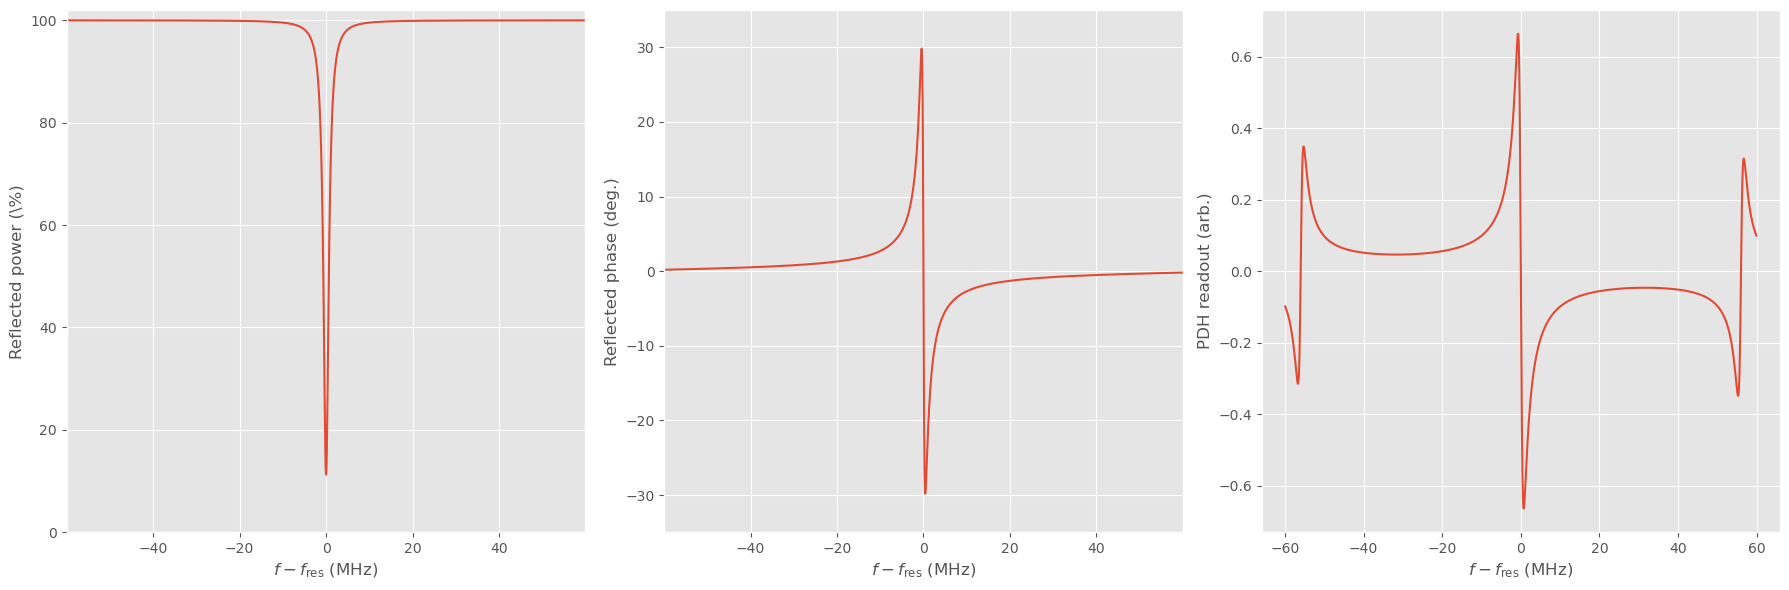

In [2]:
# Call the function with the desired parameters
L = 1.  # length of the optical cavity
fm = 56e6  # frequency of the sideband signal
r1 = .99  # input mirror reflectivity
r2 = .98  # end mirror reflectivity

f, R, pdh, fsr = MCdf.PDH(L, fm,r1,r2)

# Set up subplots and plot the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot Reflected power
axes[0].plot(f/1e6, 100*np.abs(R)**2)
axes[0].axis([-.4*fsr/1e6, .4*fsr/1e6, 0, 102])
axes[0].set_ylabel('Reflected power (\%)')
axes[0].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot Reflected phase
axes[1].plot(f/1e6, 180*np.angle(R)/np.pi)
axes[1].axis([-.4*fsr/1e6, .4*fsr/1e6, -35, 35])
axes[1].set_ylabel('Reflected phase (deg.)')
axes[1].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

# Plot PDH readout
axes[2].plot(f/1e6, np.imag(pdh))
axes[2].set_ylabel('PDH readout (arb.)')
axes[2].set_xlabel('$f-f_\mathrm{res}$ (MHz)')

plt.tight_layout()  # Adjust the layout to avoid overlapping
plt.show()

## Plot the transmission of a MC from the parameters

Determine the parameters intervals (cf VIR-NOT-071A-08).

In [3]:
# Constants
c = 2.99792e8 # Speed of light
carrier = 1064e-9 # Carrier wavelength (m)
f = c / carrier # Carrier frequency (Hz)
fm = [6e6, 56e6] # Sidebands frequency (Hz)
R1 = 0.99; T1=np.sqrt(1-R1) # mirror 1
R2 = 0.99; T2=np.sqrt(1-R2) # mirror 2
n = 1.45 # Cavity index
sidebands_trans_min, TEM_limit = 0.90, 0.01 # Sidebands & HOMs transmissions limits
L_lim, F_lim, RoC_lim = [10e-3, 30e-2], [5, 500], [0,0] # Parameters limits
nm_max = 10 # Number of HOMs to consider
FL_lim=[0,0]; RL_lim=[0,0]
k=2*np.pi*f/c

print("-----Parameters intervals-----")
# Losses limitations
losses_max=1/100; P=30/1000000 # P being the loss per face
if np.pi*losses_max/(4*P)<F_lim[1]: F_lim[1]=np.pi*losses_max/(4*P)
print(round(F_lim[0],4),"<F<",round(F_lim[1],4))

# Sidebands transmission
FL_lim[1]=np.sqrt(((1-sidebands_trans_min)*c**2)/(16*sidebands_trans_min*fm[1]**2))
L_lim[1]=FL_lim[1]/F_lim[0]
print(round(L_lim[0]*1e2,4),"<L (cm)<",round(L_lim[1]*1e2,4))

# Filtering of higher modes
RL_lim[1]=TEM_limit*(2*FL_lim[1]/(n*np.pi))**2
RoC_lim[0]=RL_lim[1]/L_lim[1]; RoC_lim[1]=RL_lim[1]/L_lim[0]
print(round(RoC_lim[0]*1e2,4),"<RoC (cm)<",round(RoC_lim[1]*1e2,4))

-----Parameters intervals-----
5 <F< 261.7994
1.0 <L (cm)< 8.9224
0.43 <RoC (cm)< 3.8364


Loop on the parameters to find the best ones (i.e. the ones giving the minimal HOMs transmissions).

In [4]:
# TEM_limit=0.1 # Max transmission allowed for T01

precisions=[1e-1, 1e-3, 1e-3] # Precisions on F, L (m), and r (m)
T=[[],[]]; Tbefore=[[1]*len(fm),[1]*nm_max]

for F in np.arange(F_lim[0],F_lim[1],precisions[0]): # Scan on the finesse
  FL_max=(c*np.sqrt(1-sidebands_trans_min))/(4*fm[-1]*np.sqrt(sidebands_trans_min)) # Making sure that we respect the condition on FL
  L_max=min(FL_max/F, L_lim[1])
    
  for L in np.arange(L_lim[0], L_max, precisions[1]): # Scan on the length
    rL_max=TEM_limit*(2*F*L/(n*np.pi))**2 # Making sure that we respect the condition on RoCL
    RoC_max = min(rL_max / L, RoC_lim[1])
    
    for RoC in np.arange(max(RoC_lim[0],L), RoC_max, precisions[2]): # Scan on the RoC
        g=1-L/RoC
        for i in range(len(fm)):
            T[0].append(MCdf.Airy(F,L,fm[i])) # Transmissions of SB
        for i in range(1,nm_max+1):
            T[1].append(MCdf.Tnm(F,g,i)) # Transmissions of TEM modes
        if T[0][-1]>=TEM_limit:
          if sum(T[1])<sum(Tbefore[1]):
            Parameters=[F,L,RoC] # if the parameters respects the conditions & allow a lower transmissions of the HOMs we keep them
            Tparameters=T
            Tbefore=T
        T=[[],[]]

g=1-(Parameters[1]/Parameters[2]) # g=1-L/RoC

print("-----Parameters-----")
print("Length (cm)=", Parameters[1]*1e2)
print("Finesse=", Parameters[0])
print("RoC (m)=",Parameters[2])

-----Parameters-----
Length (cm)= 1.0
Finesse= 44.59999999999986
RoC (m)= 0.03399999999999998


Fix a length compatible with the resonnant conditions of the carrier. Then calculate the transmissions of the SBs & HOMs and plot them.

-----Parameters-----
Resonnant length (cm)= 1.0

-----Transmissions-----
SBs transmissions: [0.9987268361855821, 0.9000551274461126]
HOMs transmissions: [1.0, 0.004199797271368876, 0.0014914633928371308, 0.0012666915209632187, 0.0021974890247688952, 0.016474509845413772, 0.014221848947240798, 0.0021159660424417332, 0.001258997777505311, 0.0015222483906564672, 0.004502162049241312]
df (MHz)= 2734.9663657422334


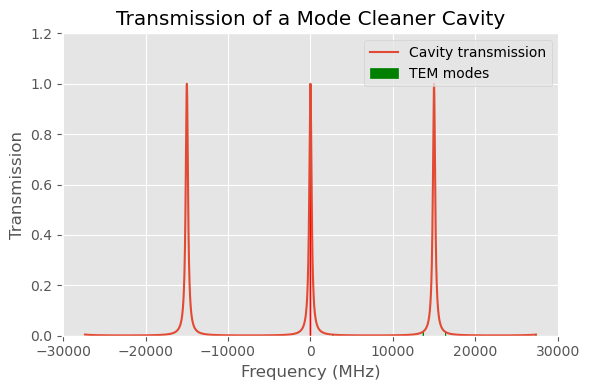

In [5]:
# Find resonnant length for the carrier transmission
Parameters[1] = MCdf.get_lengths(Parameters[1], carrier, g)
g = 1-(Parameters[1]/Parameters[2])

print("-----Parameters-----")
print("Resonnant length (cm)=", L*1e2)
print()

# Transmissions
T = [MCdf.Airy(Parameters[0], Parameters[1], freq) for freq in fm] # of the SBs
TEM = [MCdf.Tnm(Parameters[0], g, i) for i in range(nm_max + 1)] # of the HOMs
df = np.arccos(np.sqrt(g)) * c / (2 * np.pi * Parameters[1]) # frequency difference between HOMs (due to the Gouy phase)

print("-----Transmissions-----")
print("SBs transmissions:",T)
print("HOMs transmissions:",TEM)
print("df (MHz)=", df/1e6)

# Plotting
plt.figure(figsize=(6, 4))
MCdf.plot_transmission(n, Parameters[1], Parameters[0], g, fm, nm_max, plt.gca()) # Calculate the transmissions etc & plot the output of the MC
plt.tight_layout()
plt.show()


## Studies of the higher order modes transmission with the RoC
Also now taking into account the HOMs of the SBs. The sum of the transmissions of the HOMs correspond to the FoM (Factor of Merit).

Length (cm)= 0.3875
Finesse= 39.40179948543941
Ideal RoC (m)= 0.090448


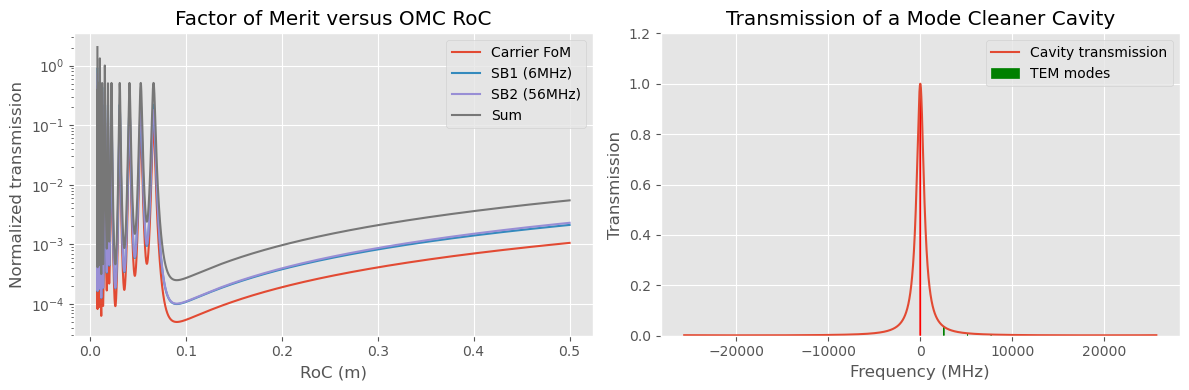

In [8]:
# Input parameters
c = 2.99792e8 # Speed of light
idxn = 1.44963 # Index of the cavity
length = 0.06200 / 16 # Physical length of the cavity
lopt = 2 * idxn * length # Optical length travelled by the beam in the cavity
fmod1 = 6.270777e6 # Frenquency of the first SB
fm = [fmod1, fmod1*9] # List of the SBs frequency
lambda_ = 1064.0e-9 # Wavelength of the carrier
SB_limit = 0.90 # SBs transmissions limit

P=[[1],[1,1]] # Input power of the carrier & SBs
P_HoMs=[np.ones(10),np.full(10, 2),np.full(10, 2)] # Input power of carrier & SBs HOMs

# Determine the max finesse that respect SB_limit
FL_max = (c * np.sqrt(1 - SB_limit)) / (4 * fm[-1] * np.sqrt(SB_limit))
Fomc = FL_max / lopt

# Call the function with the input parameters
rho_vect, FoM_vect_car, FoM_vect_SB = MCdf.FoMvsRoC(idxn, length, Fomc, fm, P, P_HoMs)

# Calculate  the total transmissions of the HOMs & the ideal RoC
FoM_vect_sum = FoM_vect_car + FoM_vect_SB[0] + FoM_vect_SB[1]
r=rho_vect[np.argmin(FoM_vect_sum)]

# Print the parameters choosed
print("Length (cm)=", length * 10**2)
print("Finesse=",Fomc)
print("Ideal RoC (m)=", r)

g=(1-length/r)

# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the first graph on ax1
ax1.plot(rho_vect, FoM_vect_car, label='Carrier FoM')
ax1.plot(rho_vect, FoM_vect_SB[0], label='SB1 (6MHz)')
ax1.plot(rho_vect, FoM_vect_SB[1], label='SB2 (56MHz)')
ax1.plot(rho_vect, FoM_vect_sum, label='Sum')
ax1.set_xlabel('RoC (m)')
ax1.set_ylabel('Normalized transmission')
ax1.set_yscale('log')
ax1.set_title('Factor of Merit versus OMC RoC')
ax1.legend()

MCdf.plot_transmission(idxn, length, Fomc, g, fm, 10, ax2)

# Display the subplots
plt.tight_layout()
plt.show()


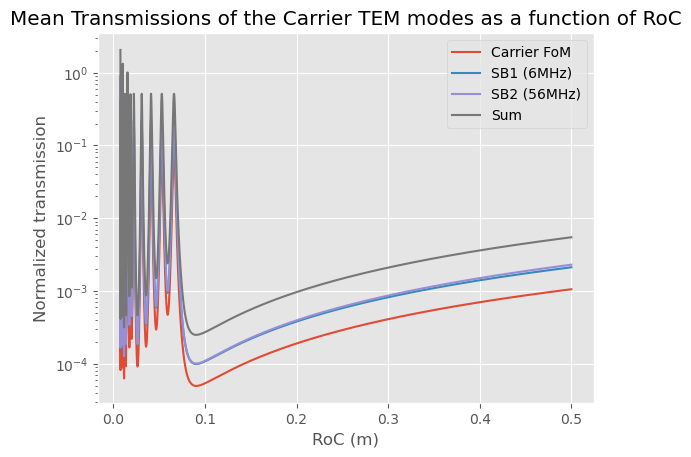

TypeError: plot_transmission() missing 1 required positional argument: 'ax'

In [7]:
# Plotting
plt.figure()
plt.plot(rho_vect, FoM_vect_car, label='Carrier FoM')
plt.plot(rho_vect, FoM_vect_SB[0], label='SB1 (6MHz)')
plt.plot(rho_vect, FoM_vect_SB[1], label='SB2 (56MHz)')
plt.plot(rho_vect, FoM_vect_sum, label='Sum')
plt.xlabel('RoC (m)')
plt.ylabel('Normalized transmission')
plt.yscale('log')
plt.title('Mean Transmissions of the Carrier TEM modes as a function of RoC')
plt.legend()
plt.show()


MCdf.plot_transmission(idxn, length, Fomc, g, fm, 10)

ideal_RoC = rho_vect[np.argmin(FoM_vect_sum)]
waist = MCdf.waist_size(lopt, ideal_RoC, lambda_,idxn)
print("Waist size (m):", waist)

P_input = 1.0  # Input power in Watts
max_pwr = MCdf.circ_power(P_input)
print("Circ power (W):", max_pwr)

#RoC2 = 0.6  # Second radius of curvature in meters, example value
#astig_loss = astigmatism_losses(lopt, ideal_RoC, RoC2, lambda_)
#print("Astigmatism losses:", astig_loss)

Loop on different values of the length.

Meshgrid of the FoM with lengthvsRoC.